In [ ]:
#! pip install pyspark -q

!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.5
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.26
Branch HEAD
Compiled by user ubuntu on 2025-02-23T20:30:46Z
Revision 7c29c664cdc9321205a98a14858aaf8daaa19db2
Url https://github.com/apache/spark
Type --help for more information.


In [ ]:
from google.colab import drive

# Mount the Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Read data into a Spark dataframe

In [ ]:
#!ls /content/drive/MyDrive

In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession\
        .builder\
        .appName("IMDb Details")\
        .getOrCreate()

In [ ]:
# Read Parquet file into a Spark DataFrame
df_parquet = spark.read.parquet('/content/drive/MyDrive/movie-recommendation-system/User-Movie-data.parquet')

In [ ]:
df_parquet.show(5)

+------+---------------+------+-------+------+------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+---------------+
|imdbId|          Title|UserID|MovieID|Genres|Rating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|avgRating|     directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|       director|
+------+---------------+------+-------+------+------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+---------------+
|109068|Airheads (1994)|    26|    413|Comedy|     2| 978139790|2000-12-30 01:29:50|     M| 25|         7|   23112|  2.81936|Michael Lehmann|    413|Steve Buscemi, Ch...|       Airheads|      92|        6.2|Three would be ro...|Michael Lehmann|
|109068|Airheads (19

### This dataset includes movie-related information such as movie and user IDs, ratings, genres, and movie details (e.g., title, director, plot). It also contains user demographics (e.g., gender, age, occupation), timestamps, and additional movie attributes like runtime, IMDb rating, and cast. Some fields allow missing values.

In [ ]:
df_parquet.printSchema()
df_parquet.count()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- avgRating: double (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: string (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- director: string (nullable = true)



916355

In [ ]:
from pyspark.sql import functions as F

#Rename 'Rating' to 'UserRating' and convert 'UserRating' and 'avgRating' to integer type
df_parquet_cleaned = df_parquet \
    .withColumnRenamed('Rating', 'UserRating') \
    .withColumn('UserRating', F.col('UserRating').cast('int')) \
    .withColumn('avgRating', F.col('avgRating').cast('int'))

#dropping the 'director' column
df_parquet_cleaned = df_parquet_cleaned.drop('director')
df_parquet_cleaned.show(5)

+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+
|imdbId|          Title|UserID|MovieID|Genres|UserRating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|avgRating|     directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|
+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+
|109068|Airheads (1994)|    26|    413|Comedy|         2| 978139790|2000-12-30 01:29:50|     M| 25|         7|   23112|        2|Michael Lehmann|    413|Steve Buscemi, Ch...|       Airheads|      92|        6.2|Three would be ro...|
|109068|Airheads (1994)|    48|    413|Comedy|         3| 978147204|

##### This code defines a User Defined Function (UDF) to map occupation codes to their corresponding occupation names using a dictionary. It then applies this UDF to a DataFrame (`df_parquet_cleaned`) to add a new column, `Occupation_Name`, and displays the first 5 rows of the updated DataFrame. I picked this up from the meta data
   Occupation Codes
   
    *  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

In [ ]:
from pyspark.sql.functions import col, lit, udf
from pyspark.sql.types import StringType

# Occupation mapping dictionary
occupation_dict = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

# User Defined Function to map the occupation code to the occupation name
occupation_udf = udf(lambda x: occupation_dict.get(x, "Unknown"), StringType())

# Adding the occupation name to the Parquet DataFrame
df_parquet_cleaned = df_parquet_cleaned.withColumn("Occupation_Name", occupation_udf(col("Occupation")))

df_parquet_cleaned.show(5)


+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+--------------------+
|imdbId|          Title|UserID|MovieID|Genres|UserRating| Timestamp|          date_time|Gender|Age|Occupation|Zip_Code|avgRating|     directedBy|item_id|            starring|localized_title|runtimes|rating_imdb|        plot_outline|     Occupation_Name|
+------+---------------+------+-------+------+----------+----------+-------------------+------+---+----------+--------+---------+---------------+-------+--------------------+---------------+--------+-----------+--------------------+--------------------+
|109068|Airheads (1994)|    26|    413|Comedy|         2| 978139790|2000-12-30 01:29:50|     M| 25|         7|   23112|        2|Michael Lehmann|    413|Steve Buscemi, Ch...|       Airheads|      92|        6.2|Three would be ro...|execut

In [ ]:
df_parquet_cleaned.printSchema()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- UserRating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- avgRating: integer (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: string (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- Occupation_Name: string (nullable = true)



In [ ]:
# Dropping  avgRating as its in the schema twice and changing rating_imdb to integet type
df_parquet_cleaned = df_parquet_cleaned.drop('avgRating')
df_parquet_cleaned = df_parquet_cleaned.withColumn('rating_imdb', df_parquet_cleaned['rating_imdb'].cast('int'))

In [ ]:
# Check for missing values
df_parquet_cleaned.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df_parquet_cleaned.columns]).show()

# Drop rows with missing UserID, MovieID, or UserRating
df_parquet_cleaned = df_parquet_cleaned.dropna(subset=["UserID", "MovieID", "UserRating"])


+------+-----+------+-------+------+----------+---------+---------+------+---+----------+--------+----------+-------+--------+---------------+--------+-----------+------------+---------------+
|imdbId|Title|UserID|MovieID|Genres|UserRating|Timestamp|date_time|Gender|Age|Occupation|Zip_Code|directedBy|item_id|starring|localized_title|runtimes|rating_imdb|plot_outline|Occupation_Name|
+------+-----+------+-------+------+----------+---------+---------+------+---+----------+--------+----------+-------+--------+---------------+--------+-----------+------------+---------------+
|     0|    0|     0|      0|     0|         0|        0|        0|     0|  0|         0|       0|        31|      0|     238|              0|       0|          1|           0|              0|
+------+-----+------+-------+------+----------+---------+---------+------+---+----------+--------+----------+-------+--------+---------------+--------+-----------+------------+---------------+



In [ ]:
df_parquet_cleaned.printSchema()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- UserRating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: integer (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- Occupation_Name: string (nullable = true)



#### Below shows a simple distribution of IMDb rating values.

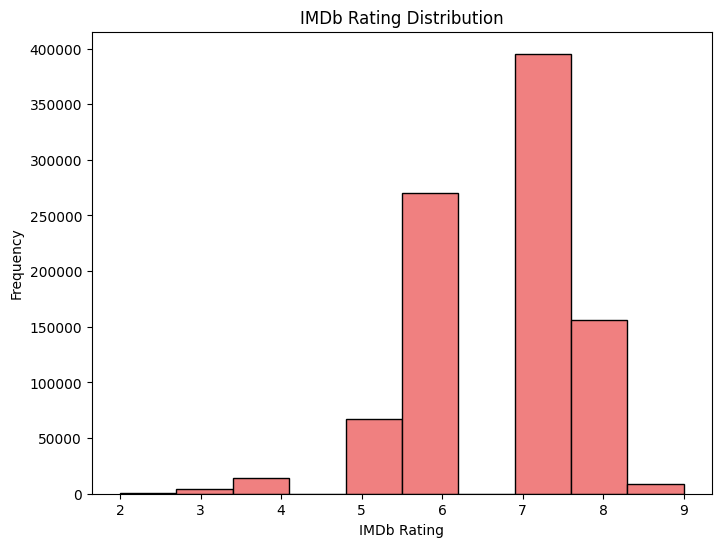

In [ ]:
import matplotlib.pyplot as plt

#converting spark dataframe to pandas

rating_imdb_data = df_parquet_cleaned.select('rating_imdb').toPandas() # This collects all data from the distributed Spark DataFrame into a single Pandas DataFrame in memory.
                                                                       # Warning: If the Spark DataFrame is too large, this can cause memory issues since Pandas loads everything into RAM.
plt.figure(figsize=(8, 6))
plt.hist(rating_imdb_data['rating_imdb'], bins=10, color='lightcoral', edgecolor='black')
plt.title('IMDb Rating Distribution')
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


scaler = MinMaxScaler()

# Normalize ratings
user_ratings_normalized = scaler.fit_transform(df_parquet_cleaned.select('UserRating').toPandas())
imdb_ratings_normalized = scaler.fit_transform(df_parquet_cleaned.select('rating_imdb').toPandas())

##### Below is a heatmap of genre preference by zip code region. This shows us the most popular genres across our geographic feature. The top 3 genres across the top 20 most active regions are Drama, Comedy, and Action.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

total_rows = df_parquet.count()

# calculate middle index for splitting due to memory limitations
half_rows = total_rows // 2

# Create a copy of the cleaned dataframe
df = df_parquet_cleaned.limit(half_rows).toPandas()

# Split the Genres column into separate columns
genres_split = df['Genres'].str.get_dummies(sep='|')

# Merge the genres back with the original DataFrame
df = pd.concat([df, genres_split], axis=1)

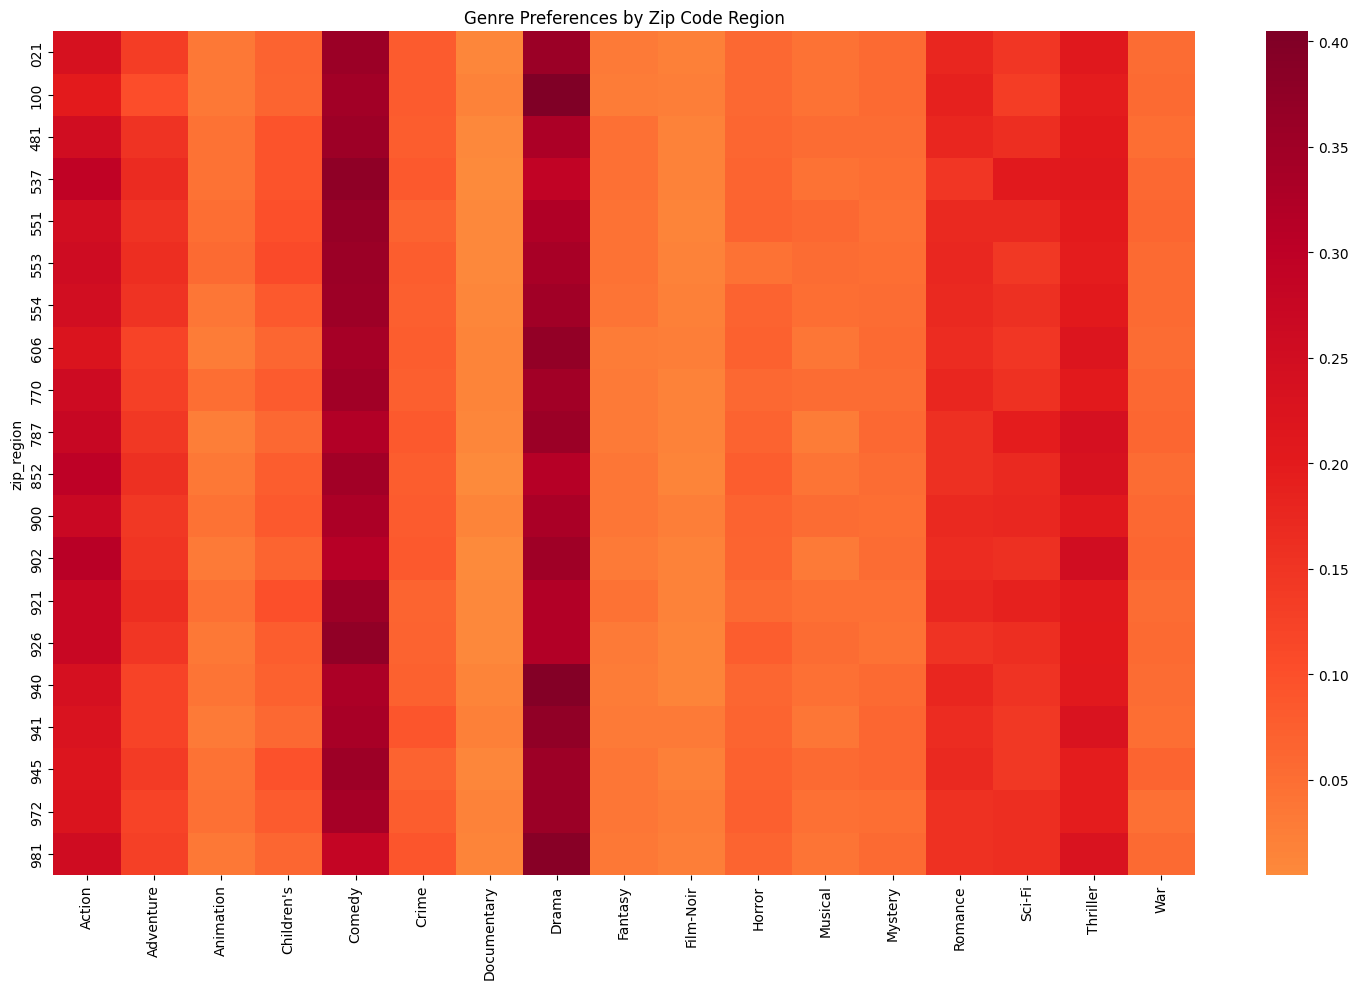

In [ ]:
# Extract first 3 digits of zipcode for regional analysis
df['zip_region'] = df['Zip_Code'].astype(str).str[:3]

genre_cols = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy',
             'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
             'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
             'Thriller', 'War']

# Filter to the top 20 most active regions in the dataset
'''
"Active regions" in this case are defined as regions with many users rating many movies
who were from the region, making the region's count high in our dataset.
'''
top_regions = df['zip_region'].value_counts().head(20).index
region_genre_dist = df[df['zip_region'].isin(top_regions)].groupby('zip_region')[genre_cols].mean()

# Create heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(region_genre_dist, cmap='YlOrRd', center=0)
plt.title('Genre Preferences by Zip Code Region')
plt.tight_layout()
plt.show()

This KDE plot compares the **distribution of normalized user ratings and IMDb ratings**, revealing key differences in rating behaviors. The sharp peaks in both curves suggest that ratings are **not smoothly distributed**, but instead cluster at specific values. This implies that users and IMDb often assign **discrete ratings**, such as 1–10, rather than spreading their scores continuously.  

The blue curve (**User Ratings**) and the orange curve (**IMDb Ratings**) have peaks at different points, indicating **differences in rating preferences**. IMDb ratings show **higher density** around 0.6 and 0.8, suggesting that users on IMDb tend to favor specific values. Meanwhile, user ratings appear **more spread out**, showing a different rating behavior.  

The distribution is **non-Gaussian**, meaning it does not follow a traditional bell curve. Instead, the multiple sharp peaks suggest **categorical or fixed-step ratings**, which KDE may not represent optimally. The plot could be improved by adjusting the **bandwidth (smoothing parameter)** to reduce the extreme peaks or by using a **histogram** instead, which better suits discrete data.

<ipython-input-18-46d18668090a>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(
<ipython-input-18-46d18668090a>:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(


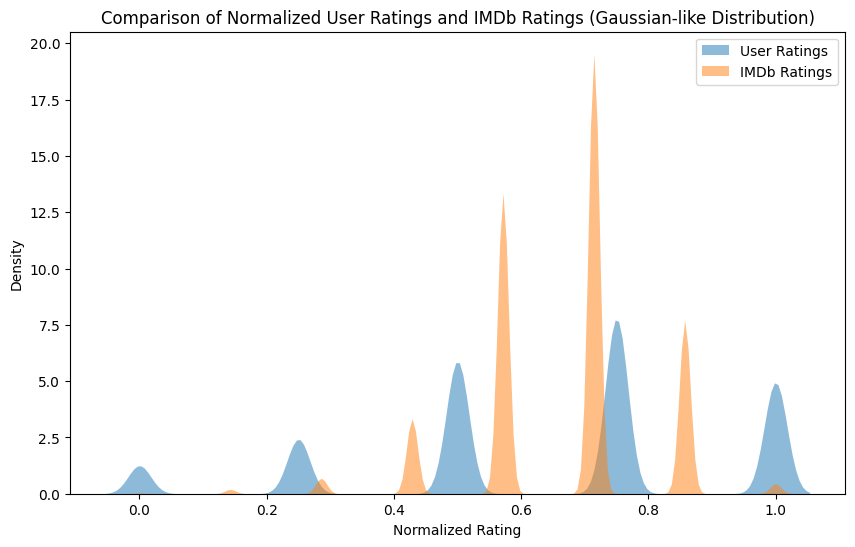

In [ ]:
ratings_df = pd.DataFrame({
    'UserRatings': user_ratings_normalized.flatten(),
    'IMDbRatings': imdb_ratings_normalized.flatten()
})
# Plotting gaussian-like distributions of both normalized ratings using KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=ratings_df, x="UserRatings", fill=True, common_norm=False,
    palette="Blues", alpha=.5, linewidth=0, label='User Ratings'
)

sns.kdeplot(
            data=ratings_df, x="IMDbRatings", fill=True, common_norm=False,
            palette="YlOrBr", alpha=.5, linewidth=0, label='IMDb Ratings'
        )

plt.title('Comparison of Normalized User Ratings and IMDb Ratings (Gaussian-like Distribution)')
plt.xlabel('Normalized Rating')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

##### Below table shows that programmers have the highest average user rating of 3.64, while writers have the lowest at 3.48. Occupations with large user bases, such as college/grad students and others/not specified, have average ratings around 3.53, possibly reflecting a wider range of opinions.

##### Smaller groups like technicians/engineers and sales/marketing show higher ratings of 3.61, suggesting more positive feedback in specialized roles. Occupations like academic/educators and executives/managers have moderate ratings, around 3.56–3.59, indicating balanced user sentiment. Overall, technical and specialized roles tend to receive higher ratings than larger, diverse groups.

In [ ]:
# Group by Occupation and calculate average user rating for each occupation
occupation_avg_rating = df_parquet_cleaned.groupBy("Occupation_Name") \
    .agg(
        F.avg("UserRating").alias("Avg_UserRating"),  # Calculate average user rating
        F.count("UserID").alias("User_Count")  # Count the number of users in each occupation
       )

# Sort by User_Count in descending order and take the top 10 occupations
top_10_occupations = occupation_avg_rating.orderBy(F.col("User_Count").desc()).limit(10)
top_10_occupations.show()


+--------------------+------------------+----------+
|     Occupation_Name|    Avg_UserRating|User_Count|
+--------------------+------------------+----------+
|college/grad student| 3.526505472553997|    120145|
|other or not spec...|3.5293792826485277|    119523|
|executive/managerial|3.5902248652666793|     96858|
|   academic/educator| 3.566375183506734|     78335|
| technician/engineer| 3.606288684574244|     66564|
|              writer|3.4826946510739685|     54983|
|          programmer|3.6414716748768474|     51968|
|              artist| 3.556769804696072|     45570|
|     sales/marketing|3.6084449158159884|     45258|
|       self-employed| 3.588229714990278|     42174|
+--------------------+------------------+----------+



##### The plot highlights the top 10 occupations by user count, with "college/grad student" having the highest count (120,145) and "self-employed" the lowest (42,174). Occupations with higher user counts, such as "executive/managerial" and "academic/educator," suggest more stable ratings, while those with lower counts may introduce more variability.

<ipython-input-20-751f5c6d0496>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-20-751f5c6d0496>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-20-751f5c6d0496>:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


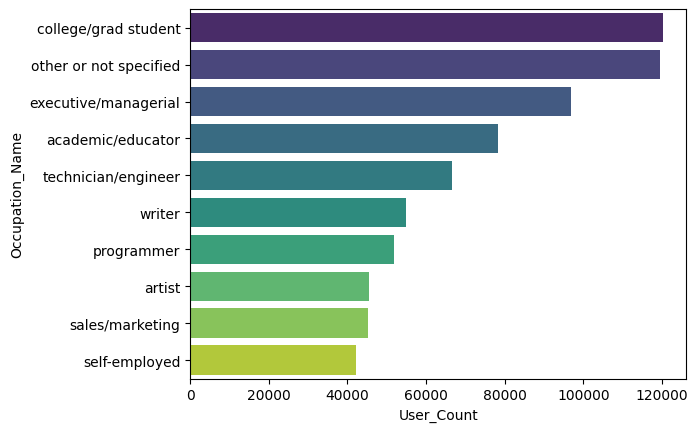

ValueError: Image size of 111781451x5618 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 1200x800 with 1 Axes>

In [ ]:
top_10_occupations_pd = top_10_occupations.toPandas()

sns.barplot(
    x="User_Count", y="Occupation_Name", data=top_10_occupations_pd,
    palette="viridis", orient="h", ci=None
)

plt.figure(figsize=(12, 8))
plt.title('Top 10 Occupations by User Count and Average Rating', fontsize=16)
plt.xlabel('User Count', fontsize=12)
plt.ylabel('Occupation Name', fontsize=12)

for index, value in enumerate(top_10_occupations_pd['User_Count']):
    plt.text(value + 50, index, str(value), color='black', ha="center", va="center")


plt.tight_layout()
plt.show()


##### The heatmap matrix below presents the average user ratings for different genre combinations across several occupations. Each occupation is associated with specific genres, and the values represent the average rating users have given to movies in these genres.

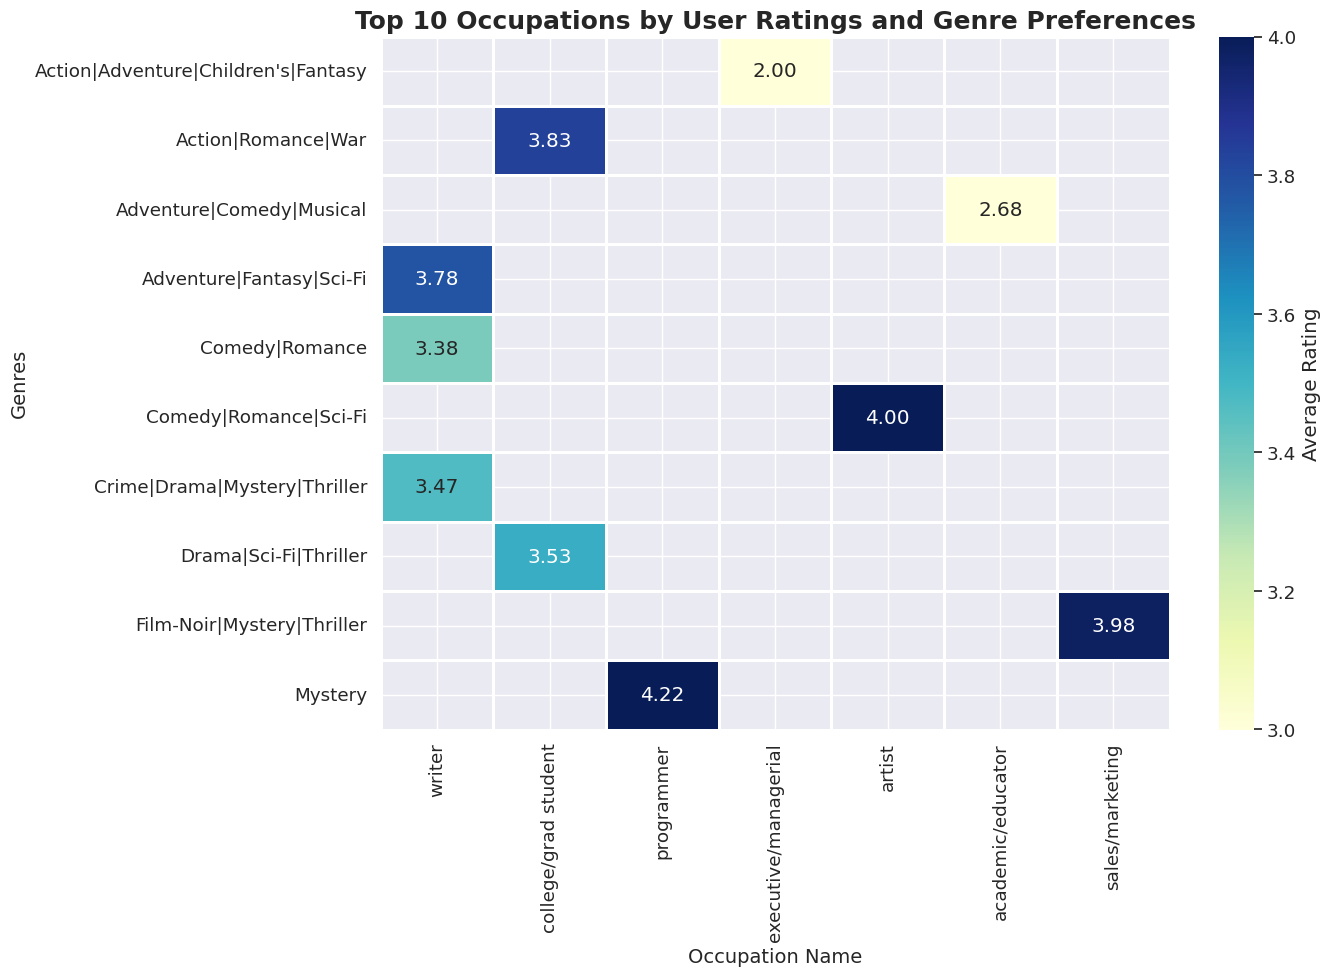

Occupation_Name                        writer  college/grad student  \
Action|Adventure|Children's|Fantasy       NaN                   NaN   
Action|Romance|War                        NaN              3.834483   
Adventure|Comedy|Musical                  NaN                   NaN   
Adventure|Fantasy|Sci-Fi             3.780822                   NaN   
Comedy|Romance                       3.384952                   NaN   
Comedy|Romance|Sci-Fi                     NaN                   NaN   
Crime|Drama|Mystery|Thriller         3.468750                   NaN   
Drama|Sci-Fi|Thriller                     NaN              3.528926   
Film-Noir|Mystery|Thriller                NaN                   NaN   
Mystery                                   NaN                   NaN   

Occupation_Name                      programmer  executive/managerial  artist  \
Action|Adventure|Children's|Fantasy         NaN                   2.0     NaN   
Action|Romance|War                          NaN         

In [ ]:

# Calculating the average rating for each occupation and genre combination
avg_ratings_by_occupation_genre = df_parquet_cleaned \
    .groupBy("Occupation_Name", "Genres") \
    .agg(F.avg("UserRating").alias("Avg_UserRating"))

# Filtering for top 10 occupations by user count
top_10_occupations = df_parquet_cleaned.groupBy("Occupation_Name") \
    .count().orderBy("count", ascending=False).limit(10)

# Joining the top 10 occupations with the genre ratings
top_10_occupation_genre_ratings = avg_ratings_by_occupation_genre \
    .join(top_10_occupations, on="Occupation_Name") \
    .select("Occupation_Name", "Genres", "Avg_UserRating").limit(10)

# Pivoting the data to create a matrix (Occupation x Genre)
pivoted_df = top_10_occupation_genre_ratings \
    .groupBy("Occupation_Name") \
    .pivot("Genres") \
    .agg(F.first("Avg_UserRating"))

pivoted_pd = pivoted_df.toPandas()

#  heatmap code
plt.figure(figsize=(14, 10))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(pivoted_pd.set_index("Occupation_Name").transpose(),
            annot=True,
            fmt='.2f',  # Display two decimal places for readability
            cmap="YlGnBu",  # Color map with pleasant gradient
            linewidths=1,   # Add gridlines for better separation
            linecolor='white',  # White gridlines for clarity
            cbar_kws={'label': 'Average Rating'},  # Color bar label
            vmin=3, vmax=4)  # Restrict color bar to range between 3 and 4


plt.title('Top 10 Occupations by User Ratings and Genre Preferences', fontsize=18, fontweight='bold')
plt.ylabel('Genres', fontsize=14)
plt.xlabel('Occupation Name', fontsize=14)
plt.tight_layout()
plt.show()

print(pivoted_pd.set_index("Occupation_Name").transpose())


The code below presents the average user ratings across various gender and genre combinations. For female users, ratings are available for genres such as Action, Comedy, Film Noir, indicating a broad spread of preferences across different types of content. This plot shows the top 10 genre preferences and average user ratings for each gender.

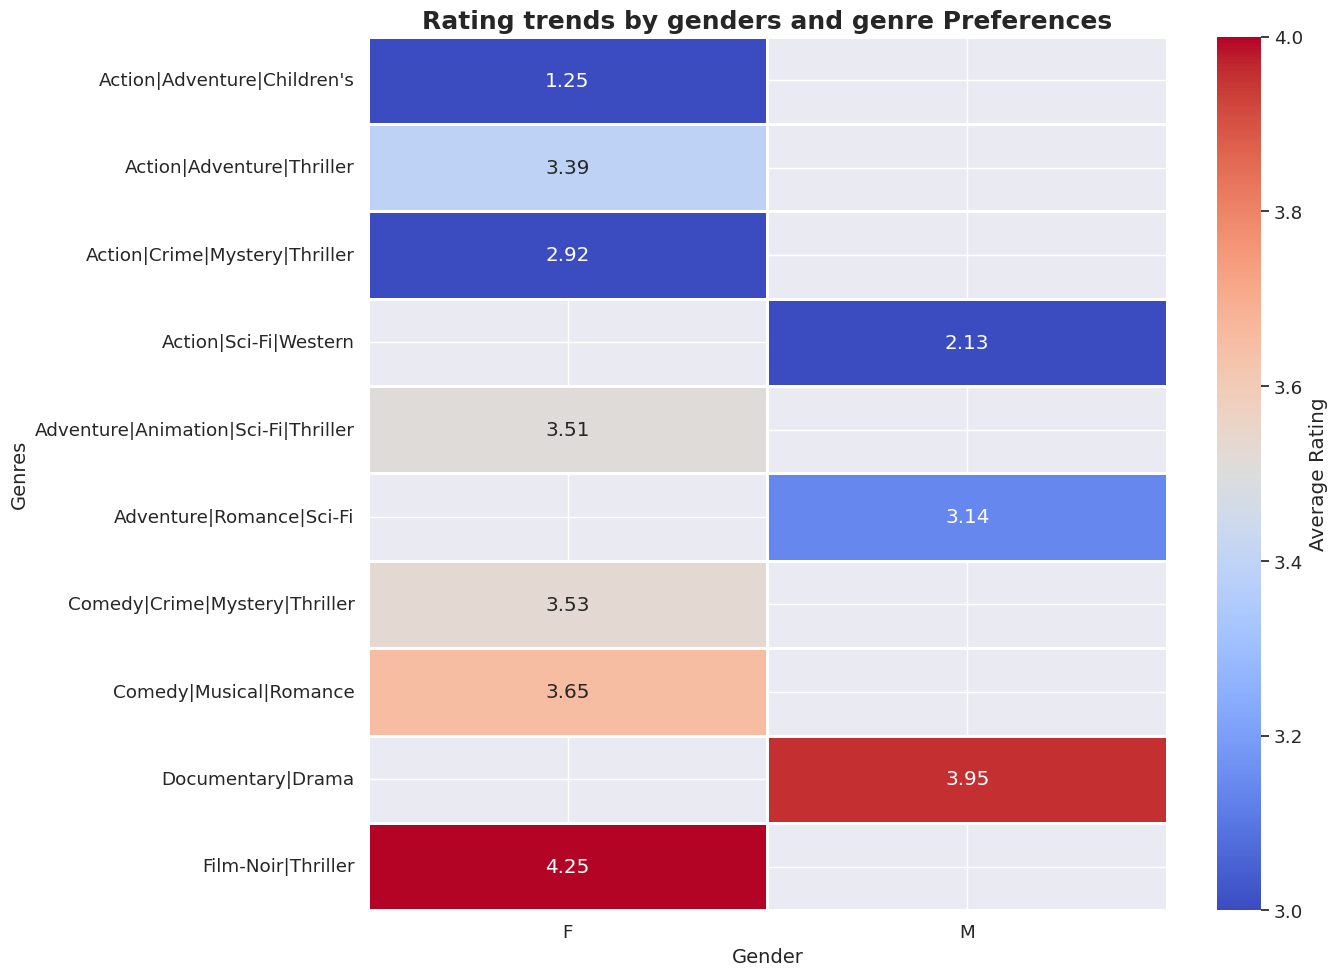

In [ ]:
avg_ratings_by_gender_genre = df_parquet_cleaned \
    .groupBy("Gender", "Genres") \
    .agg(F.avg("UserRating").alias("Avg_UserRating"))

top_10_genders = df_parquet_cleaned.groupBy("Gender") \
    .count().orderBy("count", ascending=False).limit(10)

top_10_gender_genre_ratings = avg_ratings_by_gender_genre \
    .join(top_10_genders, on="Gender") \
    .select("Gender", "Genres", "Avg_UserRating").limit(10)

pivoted_df = top_10_gender_genre_ratings \
    .groupBy("Gender") \
    .pivot("Genres") \
    .agg(F.first("Avg_UserRating"))


pivoted_pd = pivoted_df.toPandas()

plt.figure(figsize=(14, 10))
sns.set_theme(font_scale=1.2)
sns.heatmap(pivoted_pd.set_index("Gender").transpose(),
            annot=True,
            fmt='.2f',
            cmap="coolwarm",  # New color map
            linewidths=1,   # Add gridlines for better separation
            linecolor='white',  # White gridlines for clarity
            cbar_kws={'label': 'Average Rating'},  # Color bar label
            vmin=3, vmax=4)  # Restrict color bar to range between 3 and 4

plt.title('Rating trends by genders and genre Preferences', fontsize=18, fontweight='bold')
plt.ylabel('Genres', fontsize=14)
plt.xlabel('Gender', fontsize=14)
plt.tight_layout()
plt.show()

#### What t-SNE Does?
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique that converts high-dimensional data into a 2D or 3D representation that can be visualized.
It works by:

1. Preserving local relationships between data points
2. Placing similar points close together and dissimilar points far apart
3. Revealing clusters or patterns in the data

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

"""This new matrix shows each user's average preference for each genre based
    on all the movies they've rated. Now we have a single row per user that summarizes their genre preferences,
    which is what's used for the t-SNE visualization to group similar users together.
"""

# Create user-genre matrix
user_genre_matrix = df.groupby('UserID')[genre_cols].mean()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
user_clusters = tsne.fit_transform(user_genre_matrix) # gives each user an x, y value, (like a coordinate)
cluster_df = pd.DataFrame(user_clusters, columns=['x', 'y'])
cluster_df['UserID'] = user_genre_matrix.index


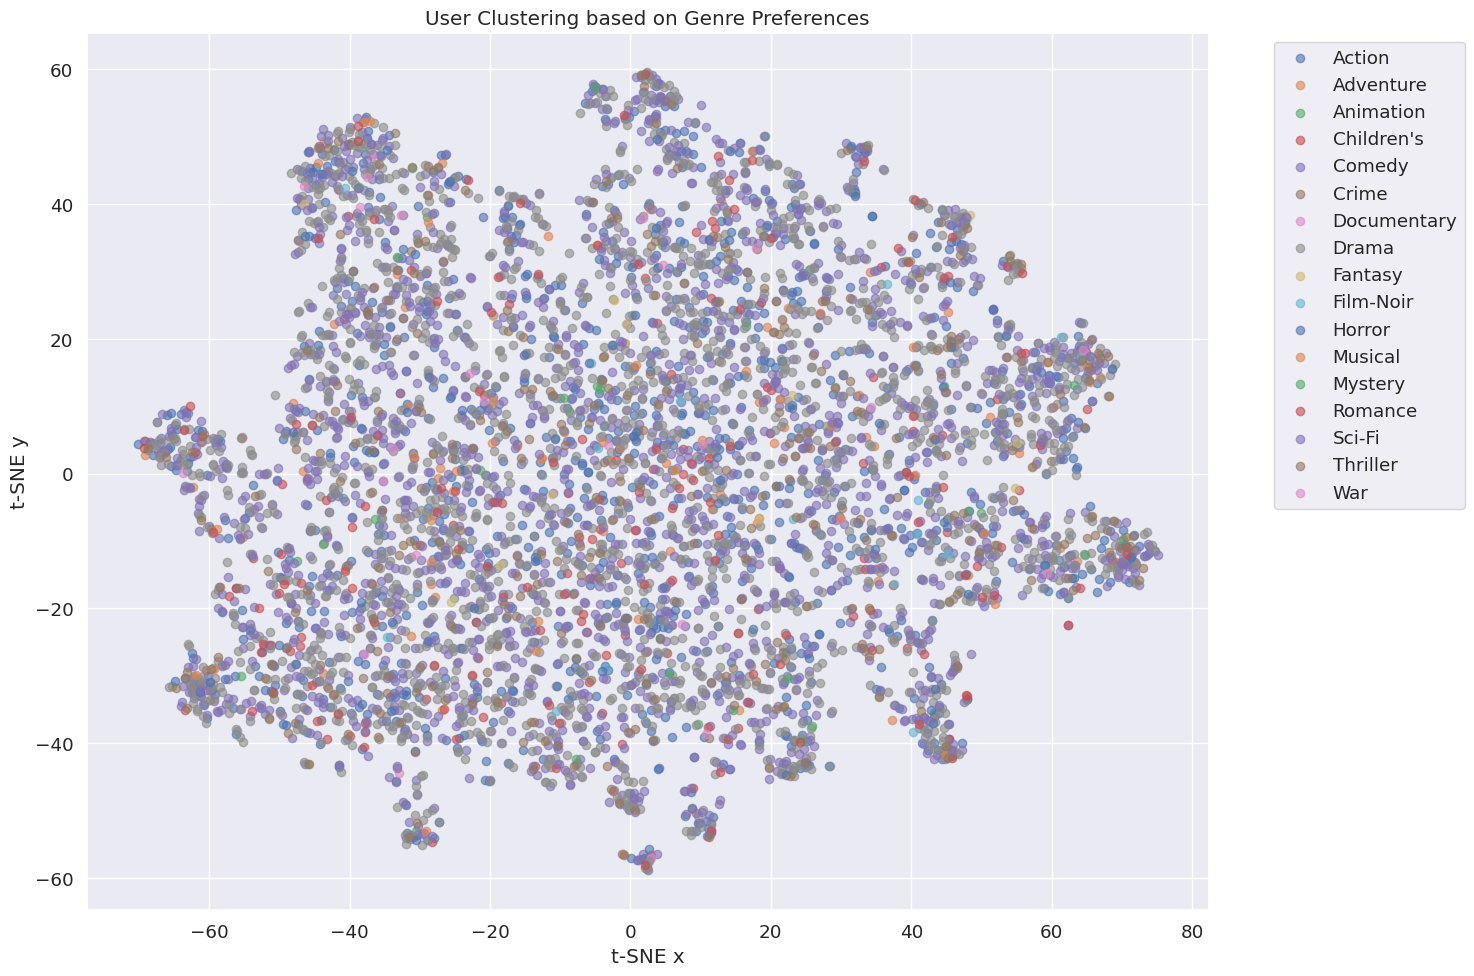

In [ ]:

# Add dominant genre for each user
user_dominant_genre = user_genre_matrix.idxmax(axis=1) #idxmax(axis=1) finds the column name (genre) with the highest value for each row (user)
cluster_df['Dominant_Genre'] = user_dominant_genre

# Visualize clusters, Plotting Each Genre Separately
plt.figure(figsize=(15, 10))
for genre in genre_cols:
    mask = cluster_df['Dominant_Genre'] == genre
    if sum(mask) > 0:  # Only plot if there are users with this dominant genre
        plt.scatter(cluster_df[mask]['x'], cluster_df[mask]['y'],
                   label=genre, alpha=0.6)

plt.title('User Clustering based on Genre Preferences')
plt.xlabel('t-SNE x')
plt.ylabel('t-SNE y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('user_clusters.png', bbox_inches='tight')
plt.show()

The "User Clustering based on Genre Preferences" visualization presents a t-SNE dimensionality reduction plot that maps users into a two-dimensional space based on their genre preferences, with different colors representing different movie genres. The scattered points form a few discernable clusters and large overlapping regions, showing how users group together based on similar taste patterns. While we were expecting to observe several well-defined clusters, instead there's significant overlap between genres in the central region of the plot, suggesting many users have diverse tastes, with most falling into mixed-preference zones where multiple genres intersect. This complexity in viewer taste patterns has important implications for recommendation systems, suggesting that recommender systems should be flexible enough to suggest movies across different genres rather than pigeonholing users into strict genre-based categories.

In [ ]:
# Print some statistics about the clusters
print("\nNumber of users in each dominant genre cluster:")
print(cluster_df['Dominant_Genre'].value_counts())


Number of users in each dominant genre cluster:
Dominant_Genre
Drama          2038
Comedy         1732
Action         1009
Sci-Fi          372
Thriller        322
Romance         151
Horror          112
Children's       73
Adventure        73
Musical          33
Crime            30
Mystery          21
Animation        18
War              18
Film-Noir        16
Fantasy          14
Documentary       7
Name: count, dtype: int64


The heatmap below displays genre preferences by age. Most genres retain a fairly similar preference score across user age, with there being a preference for children's movies in younger viewers. In general, users prefer Drama, Comedy, Action, and Thriller as the top 4 genres.

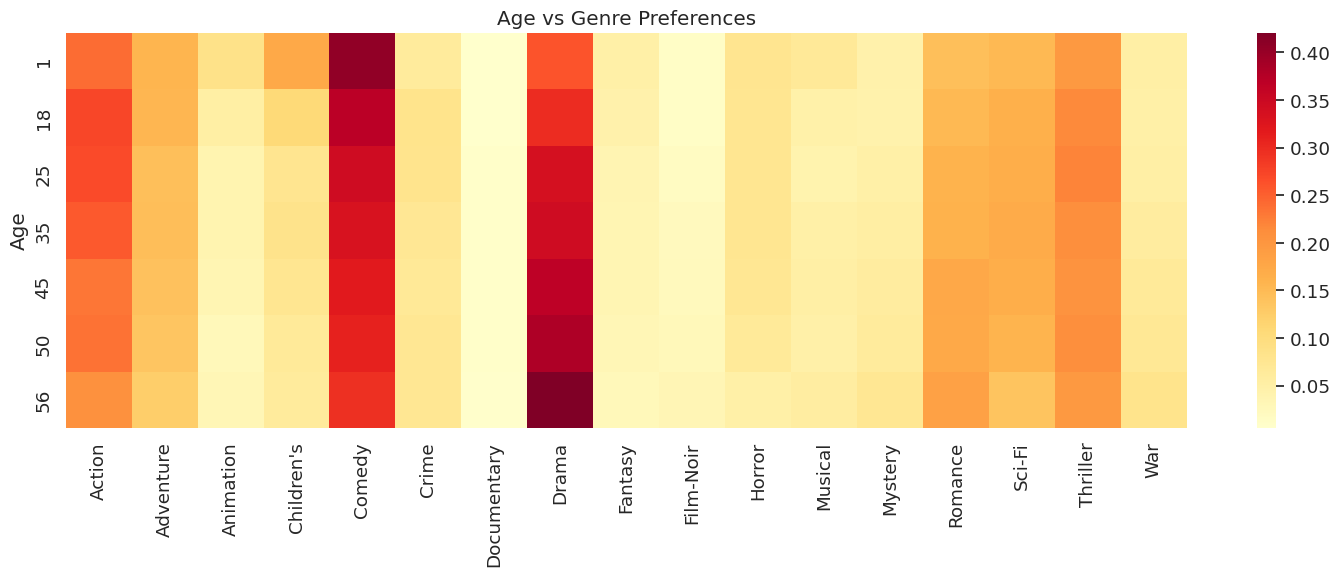

In [ ]:
# Age Distribution vs Genre Preference
plt.figure(figsize=(15, 6))
age_genre_corr = df.groupby('Age')[genre_cols].mean()
sns.heatmap(age_genre_corr, cmap='YlOrRd')
plt.title('Age vs Genre Preferences')
plt.tight_layout()
plt.show()

In [ ]:
df_parquet_cleaned.printSchema()

root
 |-- imdbId: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Genres: string (nullable = true)
 |-- UserRating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- directedBy: string (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- starring: string (nullable = true)
 |-- localized_title: string (nullable = true)
 |-- runtimes: string (nullable = true)
 |-- rating_imdb: integer (nullable = true)
 |-- plot_outline: string (nullable = true)
 |-- Occupation_Name: string (nullable = true)



In [ ]:
print(df_parquet_cleaned.columns)

['imdbId', 'Title', 'UserID', 'MovieID', 'Genres', 'UserRating', 'Timestamp', 'date_time', 'Gender', 'Age', 'Occupation', 'Zip_Code', 'directedBy', 'item_id', 'starring', 'localized_title', 'runtimes', 'rating_imdb', 'plot_outline', 'Occupation_Name']


## Data Processing

Why  we used se StringIndexer for "Genres"?

Because it converts Text to Numeric Values:

*   Models cannot process text directly, so we need a numerical representation.
*   StringIndexer assigns a unique index to each genre (e.g., "Action" → 0, "Comedy" → 1).
*   Handles New/Unseen Categories Gracefully, With handleInvalid="keep", new genres that were not in the training data won’t break the pipeline.
*   Prepares for One-Hot Encoding: We don't directly feed indexed values into the model because they might introduce an unintended order. Instead, we pass the indexed values into OneHotEncoder, which creates independent binary features.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import Bucketizer

half_rows = total_rows // 20
df=df_parquet_cleaned.limit(half_rows)
df = df_parquet_cleaned.na.fill({
    "UserRating": df_parquet_cleaned.agg(F.avg("UserRating")).collect()[0][0],  # Mean for numeric
    "Genres": "Unknown",  # Default value for categorical
    "rating_imdb": df_parquet_cleaned.agg(F.avg("rating_imdb")).collect()[0][0]  # Mean for IMDB ratings
})

df = df.withColumn("UserRating", F.col("UserRating").cast(IntegerType())) \
       .withColumn("rating_imdb", F.col("rating_imdb").cast(DoubleType())) \
       .withColumn("Year", F.year(F.col("date_time")))


In [ ]:
df = df.withColumn("Month", F.month(F.col("date_time"))) \
       .withColumn("Day", F.dayofmonth(F.col("date_time"))) \
       .withColumn("DayOfWeek", F.dayofweek(F.col("date_time")))

# StringIndexer converts string categories to indices
indexer_genres = StringIndexer(inputCol="Genres", outputCol="GenresIndex", handleInvalid="keep")
indexer_occupation = StringIndexer(inputCol="Occupation_Name", outputCol="OccupationIndex", handleInvalid="keep")
indexer_gender = StringIndexer(inputCol="Gender", outputCol="GenderIndex", handleInvalid="keep")
# OneHotEncoder converts indices to one-hot encoded vectors
encoder_genres = OneHotEncoder(inputCol="GenresIndex", outputCol="GenresVec")
encoder_occupation = OneHotEncoder(inputCol="OccupationIndex", outputCol="OccupationVec")
encoder_gender = OneHotEncoder(inputCol="GenderIndex", outputCol="GenderVec")

df = df.withColumn("NormUserRating", (F.col("UserRating") - 1) / 4)

In [ ]:
preprocessing_stages = [
    indexer_genres, encoder_genres,
    indexer_occupation, encoder_occupation,
    indexer_gender, encoder_gender
                       ]

preprocessing_pipeline = Pipeline(stages=preprocessing_stages)
preprocessor = preprocessing_pipeline.fit(df)
df_processed = preprocessor.transform(df)

(training, test) = df_processed.randomSplit([0.8, 0.2], seed=42)

In [ ]:

als = ALS(
    maxIter=10,               # Maximum number of iterations
    regParam=0.1,             # Regularization parameter to prevent overfitting
    userCol="UserID",         # Column containing user IDs
    itemCol="MovieID",        # Column containing movie IDs
    ratingCol="NormUserRating", # Column containing normalized ratings
    coldStartStrategy="drop"  # How to handle users/items with no ratings in the test set
)

In [ ]:
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [5, 10, 20]) \
    .addGrid(als.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(als.maxIter, [5, 10, 15]) \
    .build()

evaluator = RegressionEvaluator(
    metricName="rmse",              # Root Mean Squared Error
    labelCol="NormUserRating",      # Actual ratings
    predictionCol="prediction"      # Predicted ratings
)

cv = CrossValidator(
    estimator=als,                  # Model to tune
    estimatorParamMaps=param_grid,  # Parameter grid
    evaluator=evaluator,            # How to evaluate model
    numFolds=3                      # Number of cross-validation folds
)

In [ ]:
print("Training ALS Model with Cross-Validation")
cv_model = cv.fit(training)
best_als_model = cv_model.bestModel
print(f"Best ALS model parameters: rank={best_als_model._java_obj.parent().getRank()}, " +
      f"regParam={best_als_model._java_obj.parent().getRegParam()}, " +
      f"maxIter={best_als_model._java_obj.parent().getMaxIter()}")

predictions = best_als_model.transform(test)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) for ALS = {rmse}")

Training ALS Model with Cross-Validation
Best ALS model parameters: rank=5, regParam=0.01, maxIter=15
Root Mean Squared Error (RMSE) for ALS = 0.21603411568853825


For the model, the RMSE is about 0.216, which means that on average, your predictions are off by about 0.216 points from the actual ratings.

In [ ]:
def get_content_based_recommendations(user_id, num_recommendations=10):
    """Generate content-based recommendations for a user"""
    user_ratings = df_processed.filter(F.col("UserID") == user_id) \
                             .select("MovieID", "Title", "UserRating", "GenresVec")

    # Get movies with high ratings (4 or 5)
    liked_movies = user_ratings.filter(F.col("UserRating") >= 4).collect()

    if not liked_movies:
        return "User has no highly rated movies for content-based recommendations"

    all_movies = df_processed.select("MovieID", "Title", "GenresVec") \
                          .filter(~F.col("MovieID").isin([m.MovieID for m in user_ratings.collect()]))

    # Function to calculate cosine similarity between vectors
    def cosine_similarity(v1, v2):
        # Convert sparse vectors to dense arrays for calculation
        v1_array = v1.toArray() if hasattr(v1, 'toArray') else v1
        v2_array = v2.toArray() if hasattr(v2, 'toArray') else v2

        # Calculate dot product and magnitudes
        dot_product = sum(a * b for a, b in zip(v1_array, v2_array))
        magnitude1 = sum(a * a for a in v1_array) ** 0.5
        magnitude2 = sum(b * b for b in v2_array) ** 0.5

        # Return similarity (handle division by zero)
        if magnitude1 * magnitude2 == 0:
            return 0
        return dot_product / (magnitude1 * magnitude2)

    # Calculate average genre vector for the user's liked movies
    user_profile = None

    # If multiple liked movies, average their vectors
    if len(liked_movies) > 1:
        first_vec = liked_movies[0].GenresVec.toArray()
        user_profile = np.zeros_like(first_vec)

        for movie in liked_movies:
            user_profile += movie.GenresVec.toArray()

        user_profile /= len(liked_movies)
    else:
        # If only one liked movie, use its vector
        user_profile = liked_movies[0].GenresVec.toArray()

    all_movies_collected = all_movies.collect()

    movie_scores = []
    for movie in all_movies_collected:
        similarity = cosine_similarity(user_profile, movie.GenresVec)
        movie_scores.append((movie.MovieID, movie.Title, similarity))

    movie_scores.sort(key=lambda x: x[2], reverse=True)
    return movie_scores[:num_recommendations]


# Sentiment Analysis

This transformation makes intuitive sense because:

1. Ratings 1-2 genuinely reflect negative sentiment/dislike
2. Rating 3 typically indicates a neutral response
3. Ratings 4-5 indicate positive sentiment/enjoyment

In [ ]:
sentiment_bucketizer = Bucketizer(
    splits=[0, 2.5, 3.5, 5.5],  # Boundaries for Negative (1-2), Neutral (3), Positive (4-5)
    inputCol="UserRating",
    outputCol="SentimentBucket"
)

df_with_sentiment = sentiment_bucketizer.transform(df_processed)

# Map bucket indices to sentiment labels
df_with_sentiment = df_with_sentiment.withColumn(
    "Sentiment",
    F.when(F.col("SentimentBucket") == 0, "Negative")
     .when(F.col("SentimentBucket") == 1, "Neutral")
     .otherwise("Positive")
)

# Convert IMDB rating (0-10) to same scale as user rating (1-5)
df_with_sentiment = df_with_sentiment.withColumn(
    "ScaledIMDB",
    (F.col("rating_imdb") / 2)
)

# Calculate discrepancy between ratings
df_with_sentiment = df_with_sentiment.withColumn(
    "RatingDiff",
    F.abs(F.col("ScaledIMDB") - F.col("UserRating"))
)

# Classify discrepancy level
df_with_sentiment = df_with_sentiment.withColumn(
    "DiscrepancyLevel",
    F.when(F.col("RatingDiff") < 0.5, "Low")
     .when(F.col("RatingDiff") < 1.5, "Medium")
     .otherwise("High")
)


occupation_ratings = df_with_sentiment.groupBy("Occupation_Name") \
    .agg(
        F.avg("UserRating").alias("AvgRating"),
        F.count("UserRating").alias("RatingCount")
    ) \
    .orderBy("AvgRating", ascending=False)

df_with_sentiment = df_with_sentiment.withColumn(
    "AgeGroup",
    F.when(F.col("Age") < 18, "Under 18")
     .when(F.col("Age") < 25, "18-24")
     .when(F.col("Age") < 35, "25-34")
     .when(F.col("Age") < 45, "35-44")
     .when(F.col("Age") < 55, "45-54")
     .otherwise("55+")
)

age_genre_preferences = df_with_sentiment.groupBy("AgeGroup", "Genres") \
    .agg(
        F.avg("UserRating").alias("AvgRating"),
        F.count("UserRating").alias("RatingCount")
    )\
    .filter(F.col("RatingCount") > 10).orderBy("AgeGroup", "AvgRating", ascending=False)

In [ ]:
# 1. Sentiment Distribution
sentiment_counts = df_with_sentiment.groupBy("Sentiment") \
    .agg(F.count("*").alias("Count")) \
    .orderBy("Sentiment")
sentiment_df = sentiment_counts.toPandas()

# 2. Rating Discrepancy Analysis
discrepancy_analysis = df_with_sentiment.groupBy("Sentiment", "DiscrepancyLevel") \
    .agg(F.count("*").alias("Count")) \
    .orderBy("Sentiment", "DiscrepancyLevel")
discrepancy_df = discrepancy_analysis.toPandas()

# 3. Top Occupations by Rating
top_occupations = occupation_ratings.filter(F.col("RatingCount") > 20).limit(10).toPandas()

# 4. Age Group Preferences
age_rating_analysis = df_with_sentiment.groupBy("AgeGroup") \
    .agg(
        F.avg("UserRating").alias("AvgRating"),
        F.count("*").alias("Count"),
        F.stddev("UserRating").alias("StdDev")
    ) \
    .orderBy("AgeGroup")
age_rating_df = age_rating_analysis.toPandas()

# 5. Genre Preferences by Age Group (Top 5 genres for each age group)
top_genres_by_age = pd.DataFrame()
for age_group in df_with_sentiment.select("AgeGroup").distinct().collect():
    age = age_group["AgeGroup"]
    top_genres = age_genre_preferences.filter(F.col("AgeGroup") == age) \
        .orderBy(F.col("AvgRating").desc()) \
        .limit(5) \
        .toPandas()
    top_genres["Rank"] = range(1, len(top_genres) + 1)
    top_genres_by_age = pd.concat([top_genres_by_age, top_genres])

# Create visualizations
plt.figure(figsize=(20, 15))



<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

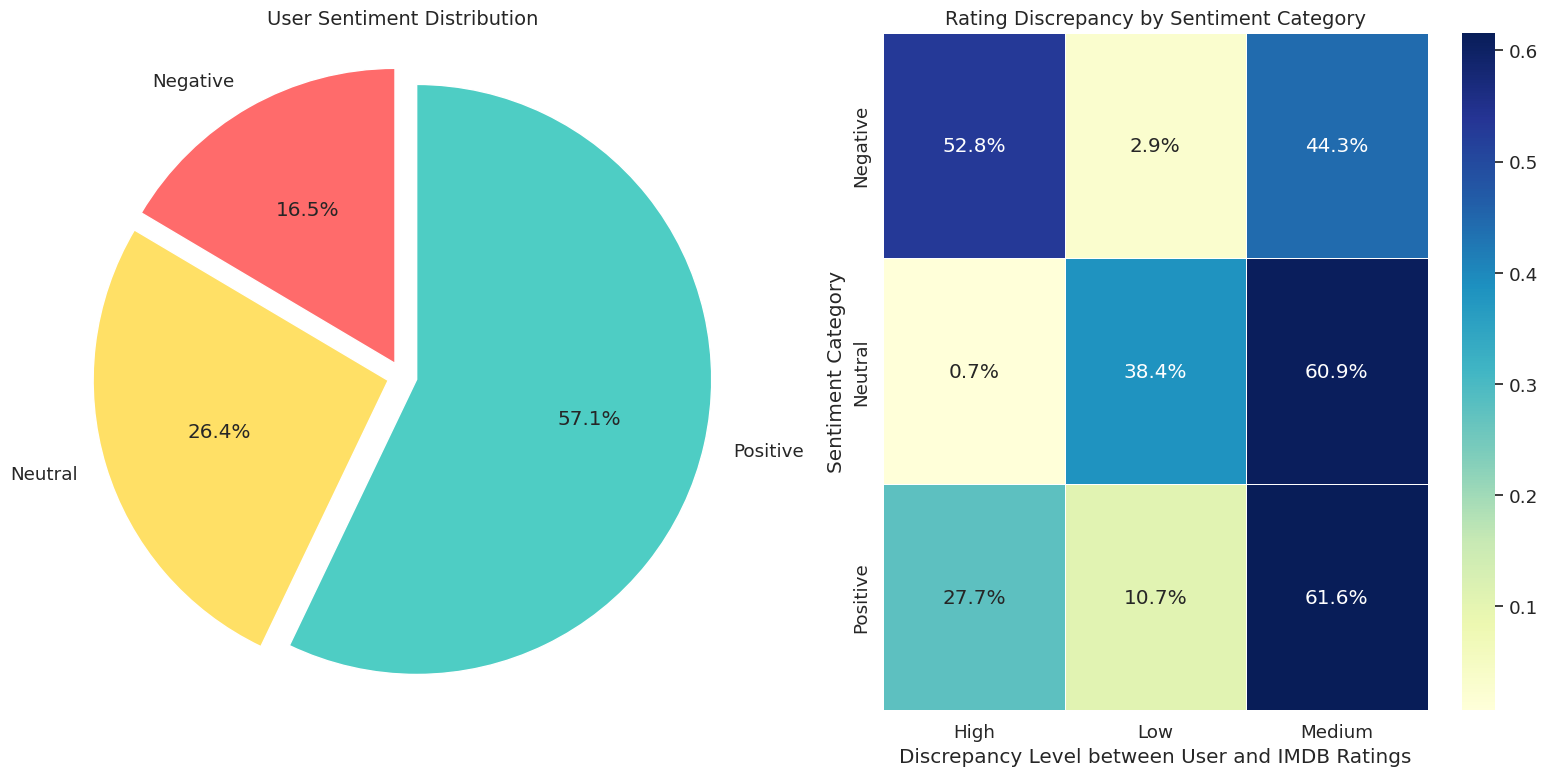

In [ ]:
# Create a figure with appropriate size and spacing
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# 1. Sentiment Distribution Pie Chart
plt.subplot(1, 2, 1)
colors = ['#ff6b6b', '#ffe066', '#4ecdc4']  # Red for negative, yellow for neutral, teal for positive
plt.pie(sentiment_df['Count'], labels=sentiment_df['Sentiment'], autopct='%1.1f%%',
        colors=colors, startangle=90, explode=[0.05, 0.05, 0.05])
plt.title('User Sentiment Distribution', fontsize=14)
plt.axis('equal')

# 2. Rating Discrepancy Heatmap
plt.subplot(1, 2, 2)
discrepancy_pivot = discrepancy_df.pivot(index='Sentiment', columns='DiscrepancyLevel', values='Count')
discrepancy_pivot = discrepancy_pivot.fillna(0)
# Normalize by row to see proportions
discrepancy_norm = discrepancy_pivot.div(discrepancy_pivot.sum(axis=1), axis=0)
sns.heatmap(discrepancy_norm, annot=True, cmap='YlGnBu', fmt='.1%', linewidths=.5)
plt.title('Rating Discrepancy by Sentiment Category', fontsize=14)
plt.xlabel('Discrepancy Level between User and IMDB Ratings')
plt.ylabel('Sentiment Category')

plt.tight_layout()

<ipython-input-39-c45598a0a1f3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AvgRating', y='Occupation_Name', data=top_occupations, palette='viridis')


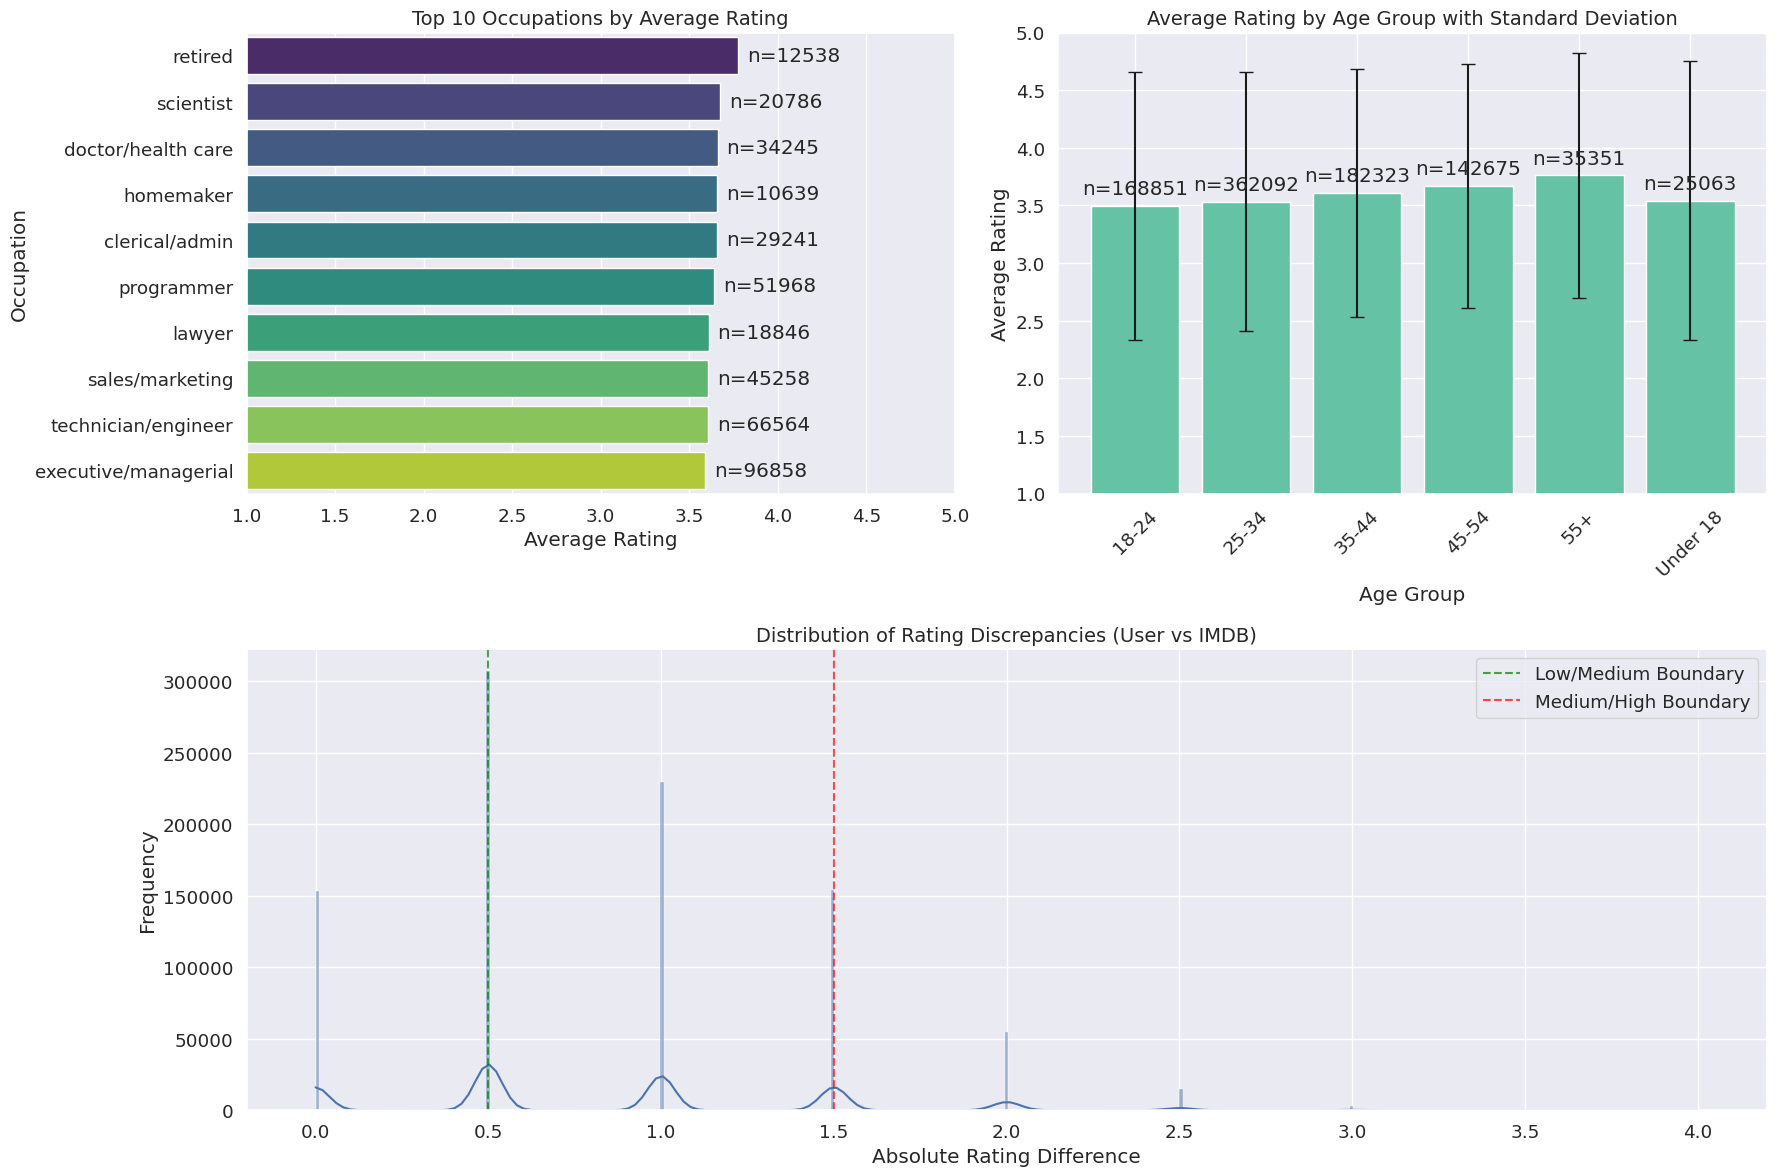

In [ ]:
# Create a new figure with appropriate size for three plots
plt.figure(figsize=(18, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# 3. Top Occupations by Average Rating
plt.subplot(2, 2, 1)
sns.barplot(x='AvgRating', y='Occupation_Name', data=top_occupations, palette='viridis')
plt.title('Top 10 Occupations by Average Rating', fontsize=14)
plt.xlabel('Average Rating')
plt.ylabel('Occupation')
plt.xlim(1, 5)  # Rating scale from 1-5
# Add count annotations to bars
for i, row in enumerate(top_occupations.itertuples()):
    plt.text(row.AvgRating + 0.05, i, f"n={row.RatingCount}", va='center')

# 4. Average Rating by Age Group
plt.subplot(2, 2, 2)
bars = plt.bar(age_rating_df['AgeGroup'], age_rating_df['AvgRating'],
        yerr=age_rating_df['StdDev'], capsize=5, color='#66c2a5')
plt.ylim(1, 5)  # Rating scale from 1-5
plt.title('Average Rating by Age Group with Standard Deviation', fontsize=14)
plt.xlabel('Age Group')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
# Add count annotations above bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f"n={age_rating_df['Count'].iloc[i]}", ha='center')

# 5. User-IMDB Rating Discrepancy Distribution
plt.subplot(2, 1, 2)  # Using bottom half of the grid for the histogram
rating_diff = df_with_sentiment.select("RatingDiff").toPandas()
sns.histplot(rating_diff, kde=True, color='#8da0cb')
plt.title('Distribution of Rating Discrepancies (User vs IMDB)', fontsize=14)
plt.xlabel('Absolute Rating Difference')
plt.ylabel('Frequency')
# Add vertical lines for discrepancy boundaries
plt.axvline(x=0.5, color='green', linestyle='--', alpha=0.7, label='Low/Medium Boundary')
plt.axvline(x=1.5, color='red', linestyle='--', alpha=0.7, label='Medium/High Boundary')
plt.legend()

plt.tight_layout()